## Word2Vec model 

**In this notebook, we train our own word2vec model on one of the Twitter datasets we found.**

In [1]:
# Importing libraries
import tempfile
import re
import json
import pandas as pd
import nltk
import gensim
import gensim.models
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
from statistics import mean
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Function for tokenization of sentences
def tokenize(text):
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token.
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [3]:
def save_model(model):
    with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
        temporary_filepath = tmp.name
        print(f'Path to your model is: {temporary_filepath}')
        model.save(temporary_filepath)

In [2]:
# We read an already cleaned twitter dataset
twitter_df = pd.read_excel('../data/twitter_mutlimodal_hate_speech/twitter_mutlimodal_hate_speech.xlsx')

In [3]:
twitter_df.drop(columns='Unnamed: 0')

,text,Homophobe,NotHate,OtherHate,Racist,Religion,Sexist
0,Nigga,True,False,False,True,True,False
1,horses are retarded,False,False,True,False,False,False
2,“NIGGA MOMMA YOUNGBOY SPITTING REAL SHIT NI...,False,True,False,False,False,False
3,xxSuGVNGxx: ran into this HOLY NIGGA TODAY 😭...,False,True,False,True,False,False
4,“EVERYbody calling you Nigger now!”,False,True,False,True,False,False
...,...,...,...,...,...,...,...
149818,would just say hes Donny the retard,False,True,True,False,False,True
149819,congrats nigga keep grinding,False,True,False,False,False,False
149820,nigga big shitty,False,True,False,True,False,False
149821,did she just say “ nigga” Rich? &amp; she sai...,False,True,False,True,False,False


In [6]:
tweets = twitter_df["text"].tolist()
tweets[: 5]

[' Nigga ',
 ' horses are retarded ',
 '“NIGGA   MOMMA YOUNGBOY  SPITTING REAL SHIT NIGGA” ',
 ' xxSuGVNGxx:  ran into this HOLY NIGGA TODAY 😭😭😭😭 ',
 '“EVERYbody calling you Nigger now!” ']

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# We do tokenization on every tweet in our dataset
tokenized_tweets = []
for tweet in tweets:
    tokenized_tweets.append(tokenize(tweet))
tokenized_tweets[: 5]

[['nigga'],
 ['horses', 'are', 'retarded'],
 ['nigga', 'momma', 'youngboy', 'spitting', 'real', 'shit', 'nigga'],
 ['xxsugvngxx', 'ran', 'into', 'this', 'holy', 'nigga', 'today'],
 ['everybody', 'calling', 'you', 'nigger', 'now']]

In [57]:
# Here we have an embdedding size of 100. We tried with smaller sizes to see if that might help with our small (at least for 
# word2vec training purposes) dataset, however we didn't get better results. Also, different window sizes we tested, but this
# current parameter setting provided the most reasonable results.

# This command is run only once, later you just skip to loading of the generated model
model = gensim.models.Word2Vec(sentences=tokenized_tweets, min_count=3, workers=4) 

In [58]:
save_model(model)

Path to your model is: C:\Users\User\AppData\Local\Temp\gensim-model-tus71v9k


In [59]:
# Copy path for saved model outputed in cell above
model = gensim.models.Word2Vec.load('C:\\Users\\User\\AppData\\Local\\Temp\\gensim-model-tus71v9k')

In [60]:
# Becuse we have a smaller dataset, we focus on the 10 most similar words to a particular term
TOP_N = 10
KEYS = { \
    "homophobe": set(), 
    "racist": set(), 
    "religion": set(), 
    "sexist": set(), 
    "hateful": set()
}
FIXED_KEYS = list(KEYS.keys())

In [5]:
# Function to get 10 most similar words to our specified terms
# No ommision of similar words is done, again because of the dataset size, but as it can be seen in the dataframe with most 
# similar words below, this is not a problem.
def get_similar_words(model):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        embeddings = []
        words = []
        for similar_word, _ in model.wv.most_similar(key, topn=TOP_N):
            words.append(similar_word)
            embeddings.append(model.wv[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [6]:
def display_df(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)
    return df

In [63]:
word_clusters, embedding_clusters = get_similar_words(model)

In [64]:
cluster_df = display_df(word_clusters)

,homophobe,racist,religion,sexist,hateful
0,informed,ignorant,securi̇ty,builder,mafsau
1,toddler,poor,violence,mrs.,idiot
2,customer,coloured,banislam,loses,incompetent
3,horrified,stupid,islam,colour,hypocrite
4,desperate,idiot,denounces,fitness,vile
5,edgy,inbred,terrorism,vehicles,utter
6,embarrassing,disgusting,kavanaugh,grinder,arrogant
7,unhinged,nazi,others,hires,deluded
8,deserves,aren,bansharialaw,steven,moron
9,witch,seriously,linked,fares,prick


In [68]:
# Below we see that our terms are quite similar to their closest words in terms of distance between the embeddings,
# however if we check the dataframe above, we wouldn't for instance say 'linked' is too related to 'religion', which implies 
# that we simply don't have enough data in our dataset to construct good relations among the words.
for i in range(len(cluster_df.columns)):
    similarity = model.wv.similarity(cluster_df.columns[i], cluster_df.iloc[0, i])
    print(f'Similarity between {cluster_df.columns[i]} and its most similar word in the vocabulary is: {similarity}.')

Similarity between homophobe and its most similar word in the vocabulary is: 0.9203298687934875.
Similarity between racist and its most similar word in the vocabulary is: 0.8958878517150879.
Similarity between religion and its most similar word in the vocabulary is: 0.9395592212677002.
Similarity between sexist and its most similar word in the vocabulary is: 0.906353235244751.
Similarity between hateful and its most similar word in the vocabulary is: 0.9611021876335144.


In [7]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [21]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    # We specify some parameters for the t-SNE (we reduce perplexity and reduce number of iterations)
    model_2d = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2000, random_state=32)
    model_2d = model_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_2d = np.array(model_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_2d, word_clusters, filename)
    
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)
    
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

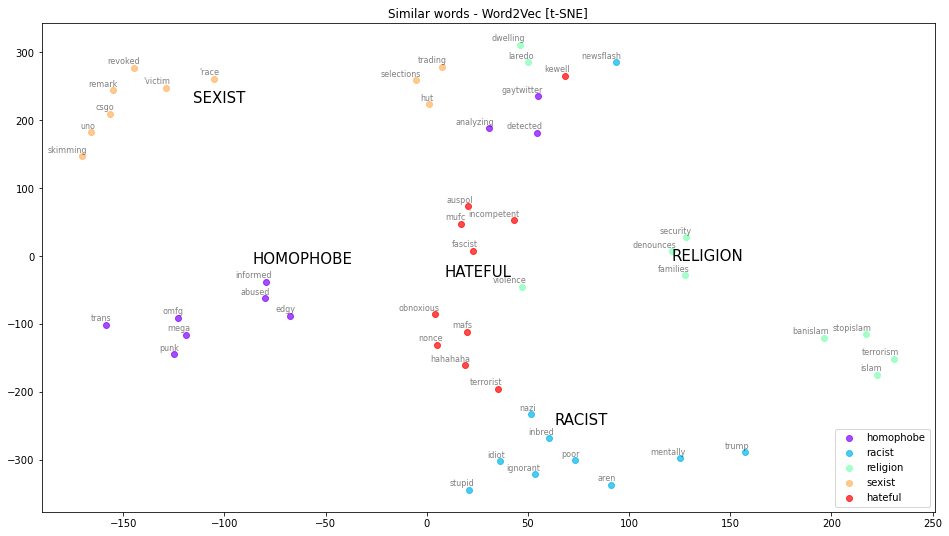

In [71]:
plotTSNE("Similar words - Word2Vec [t-SNE]", word_clusters, embedding_clusters)

**In the figure above, we can see that different terms are represented through different clusters of words. However, we also have one mixed cluster, and that's an undesired effect.**

## Training word2vec model on all datasets merged together

**If you want to again train our model, run the following three cells. Otherwise, skip them and directly load the model in the cell which comes after them.**

In [16]:
with open('../data/main_dataset_tokenized.json') as json_file:
    tokenized_sentences = json.load(json_file)

In [17]:
tokenized_sentences[0]

['islamophobic',
 'According',
 'recent',
 'OFSTED',
 'report,',
 'school',
 'Birmingham',
 'still',
 'segregating',
 'girl',
 'boys,',
 'despite',
 'Hight',
 'Court',
 'ruling',
 '2017',
 'unlawful']

In [ ]:
# Line used to train the model
model = gensim.models.Word2Vec(sentences=tokenized_sentences,
                               size=300,
                               alpha=0.05,
                               window=10, 
                               workers=200,
                               iter=50,
                               compute_loss=True) 

# model.save('word2vec_main_dataset_v2.model')

In [14]:
model = gensim.models.Word2Vec.load('C:\\Users\\User\\Downloads\\word2vec_main_dataset_v2.model')  # change path to load model

In [18]:
TOP_N = 10
KEYS = { \
    "religion": set(),
    "islamophobic": set(),
    "racist": set(),
}

FIXED_KEYS = list(KEYS.keys())

In [19]:
word_clusters, embedding_clusters = get_similar_words(model)  

In [20]:
cluster_df = display_df(word_clusters)

,religion,islamophobic,racist
0,Jews,Muslims,racism
1,Islam,Islam,ignorant
2,"religion,",Britain,white
3,doctrine,"rapes,","racist,"
4,cult,\r\n5,saying
5,Christians,Muslim,people
6,Christianity,anguish,black
7,Muslims,law,stupid
8,human,Prophet,"white,"
9,people,Mosque,stating


C:\Users\User\anaconda3\envs\nlp-course-fri\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\envs\nlp-course-fri\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


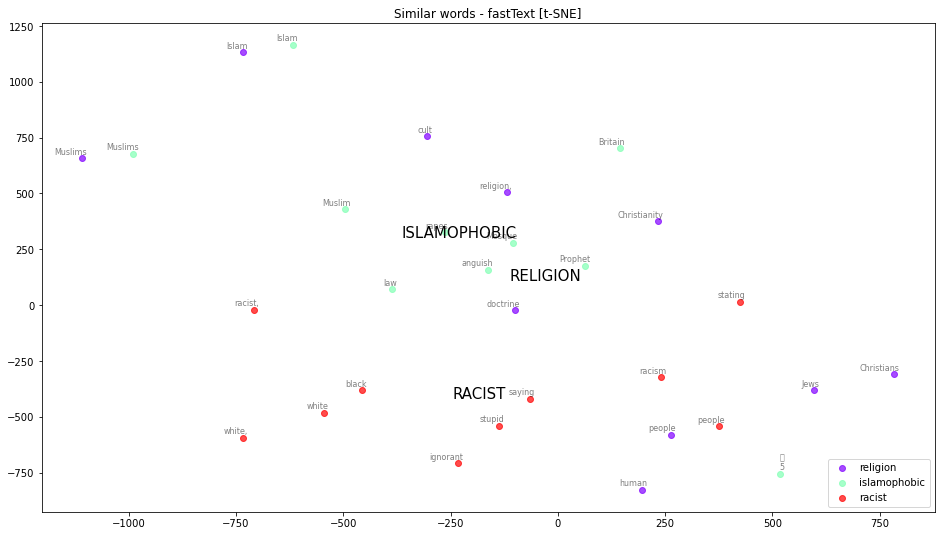

In [22]:
plotTSNE("Similar words - fastText [t-SNE]", word_clusters, embedding_clusters)

C:\Users\User\anaconda3\envs\nlp-course-fri\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\envs\nlp-course-fri\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


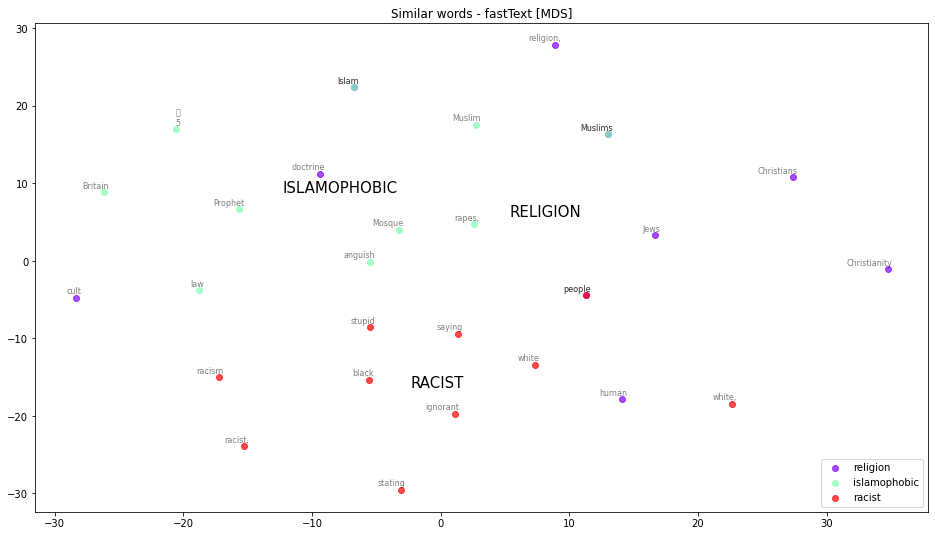

In [23]:
plotMDS("Similar words - fastText [MDS]", word_clusters, embedding_clusters)

C:\Users\User\anaconda3\envs\nlp-course-fri\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\envs\nlp-course-fri\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


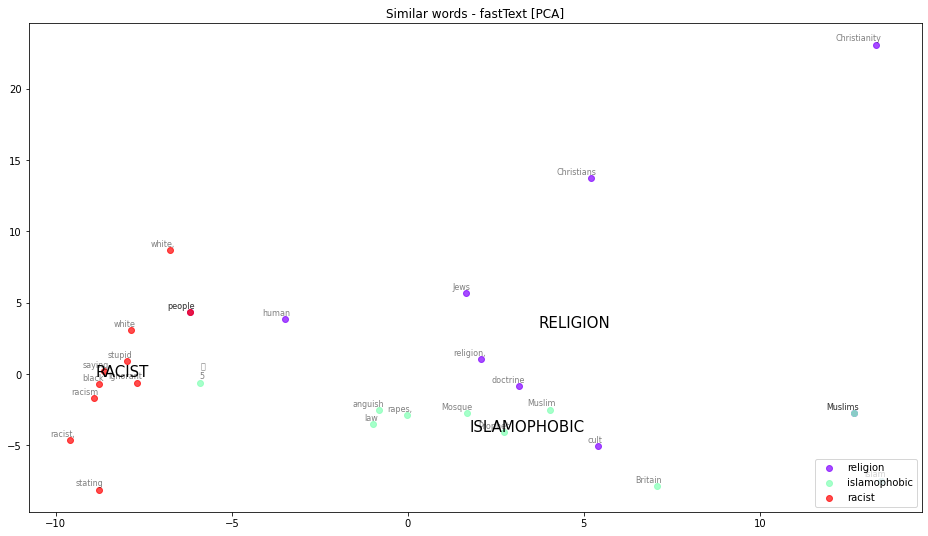

In [24]:
plotPCA("Similar words - fastText [PCA]", word_clusters, embedding_clusters)

**Although the most similar words to our terms seemed reasonable, there aren't well defined clusters in our visualisations.**